In [1]:
import matplotlib.pyplot as plt

In [2]:
import os
import json
from dataclasses import dataclass

import torch
import numpy as np

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar

from utils.helper_functions import ShiftOODDataModule, StreetHazardsOODDataModule
from utils.arguments import get_parser
from nets.wrapperood import WrapperOod
from nets.sml import max_logits, unnormalized_likelihood, SMLWithPostProcessing
from data.shift_dataset import no_pedestrian_filter, pedestrian_filter_10_15k

@dataclass
class Arguments:
    dataset_dir: str = "./datasets"
    dataset: str = ""
    checkpoint_dir: str = "./"
    ood_scores: str = "max_logits"
    boundary_suppression: bool = True
    boundary_width: int = 4
    boundary_iteration: int = 4
    dilated_smoothing: bool = True
    kernel_size: int = 7
    dilation: int = 6

def load_model(checkpoint_dir):
    # pylint: disable=no-value-for-parameter

    loaded = torch.load(checkpoint_dir, map_location="cuda" if torch.cuda.is_available() else "cpu")
    num_classes = loaded["model.classifier.classifier.3.weight"].shape[0]
    model = WrapperOod("resnet50", num_classes)
    model.load_state_dict(loaded)

    return model, num_classes

In [15]:
args = Arguments(dataset="SHIFT", ood_scores="sml_ul", checkpoint_dir="pretrained/shift_weights.ckpt")

In [17]:
if args.dataset == "SHIFT":
    dm = ShiftOODDataModule(
        os.path.join(args.dataset_dir, "SHIFT"), 512,
        os.path.join(args.dataset_dir, "COCO2014"), 352, 2,
        no_pedestrian_filter, pedestrian_filter_10_15k,
        "ood_pedestrian",
        num_workers=8, val_amount=.05
    )
elif args.dataset == "StreetHazards":
    dm = StreetHazardsOODDataModule(
        os.path.join(args.dataset_dir, "StreetHazards"), 512,
        os.path.join(args.dataset_dir, "COCO2014"), 352, 2,
        "normal",
        num_workers=8
    )

model, num_classes = load_model(args.checkpoint_dir)

if args.ood_scores == "max_logits":
    model.compute_ood_scores = max_logits
elif args.ood_scores == "unnormalized_likelihood":
    model.compute_ood_scores = unnormalized_likelihood
elif args.ood_scores == "sml_ml":
    means = torch.from_numpy(np.load(args.checkpoint_dir.replace(".ckpt", "max_logits.means")))
    variances = torch.from_numpy(np.load(args.checkpoint_dir.replace(".ckpt", "max_logits.var")))
    model.compute_ood_scores = SMLWithPostProcessing(
        torch.from_numpy(means), torch.from_numpy(np.sqrt(variances)), "max_logits",
        args.boundary_suppression, args.boundary_width, args.boundary_iteration,
        args.dilated_smoothing, args.kernel_size, args.dilation)
elif args.ood_scores == "sml_ul":
    means = np.load(args.checkpoint_dir.replace(".ckpt", "unnormalized_likelihood.means"))
    variances = np.load(args.checkpoint_dir.replace(".ckpt", "unnormalized_likelihood.var"))
    model.compute_ood_scores = SMLWithPostProcessing(
        torch.from_numpy(means), torch.from_numpy(np.sqrt(variances)), "unnormalized_likelihood",
        args.boundary_suppression, args.boundary_width, args.boundary_iteration,
        args.dilated_smoothing, args.kernel_size, args.dilation)

tr = Trainer(
    default_root_dir=os.path.dirname(args.checkpoint_dir), accelerator="auto",
    callbacks=[TQDMProgressBar(refresh_rate=2)])

# out = tr.test(model=model, datamodule=dm)
# print(out)

loading annotations into memory...
Done (t=3.38s)
creating index...
index created!


/home/mbikandi/miniconda3/envs/dev2/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mbikandi/miniconda3/envs/dev2/lib/python3.10/s ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
len(dm.shift_test)

1070

In [19]:
img, lbl = dm.shift_test[450]

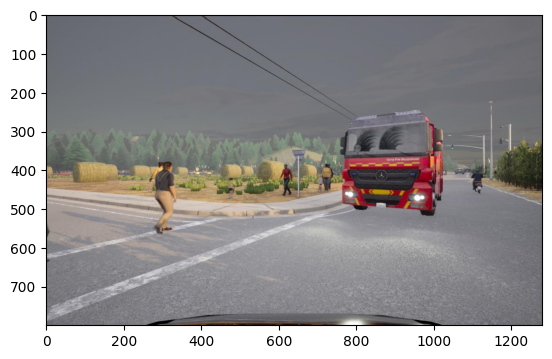

In [20]:
plt.imshow(img.permute(1,2, 0))

In [21]:
model.eval()
with torch.no_grad():
    logits, scores = model(img.unsqueeze(0))

In [25]:
ml = logits.sum(1)

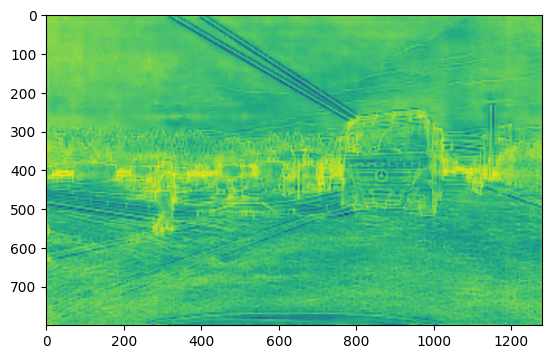

In [26]:
plt.imshow(ml[0])

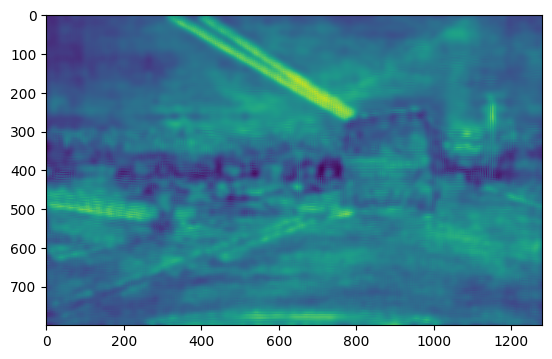

In [24]:
plt.imshow(scores[0, 0])